In [1]:
### Set up
from itertools import product
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text
)
import polars as pl
import torch
import functorch


from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

In [11]:


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def calc_power_contributions_2d(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)**2
    fourier_transform = slow_ft_2d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform



def embedding_harmonic_analysis(checkpoint, config, epoch):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    
    #out, cache = model.run_with_cache(lperms[test_mask], rperms[test_mask])
    #loss = loss_fn(out, targets[test_mask])
    
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight, 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight, 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return pl.concat([lembed_power_df, rembed_power_df], how='vertical')


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs



In [117]:
exp_dir = Path('experiments')
model_seeds = [0, 1, 2, 3, 4, 5, 6, 7]
data_seeds = [10, 11, 12, 13, 14, 15, 16, 17]

m0d1 = exp_dir / f'model_0_data_15/full_run.pth'

full_run = torch.load(m0d1, map_location='cpu')

In [118]:
list(full_run.keys())

['model',
 'config',
 'checkpoints',
 'checkpoint_epochs',
 'train_loss',
 'test_loss']

In [13]:
df = embedding_harmonic_analysis(full_run['model'], full_run['config'], full_run['checkpoint_epochs'][-1])

In [15]:
from itertools import product, permutations


run_data = []

for ms, ds in product(model_seeds, data_seeds):
    fp = exp_dir / f'model_{ms}_data_{ds}/full_run.pth'
    full_run = torch.load(fp, map_location='cpu')
    epochs = full_run['checkpoint_epochs'][-1]
    data = embedding_harmonic_analysis(full_run['model'], full_run['config'], epochs)
    data = data.insert_at_idx(0, pl.Series('model_seed', [ms] * data.shape[0]))
    data = data.insert_at_idx(1, pl.Series('data_seed', [ds] * data.shape[0]))
    run_data.append(data)

all_data = pl.concat(run_data, how='vertical')

In [47]:
id_vars = ['model_seed', 'data_seed', 'epoch', 'irrep']

df = (all_data
      .filter(pl.col('layer') == 'left_embed').select(pl.exclude('layer'))
      .melt(id_vars=id_vars)
      .groupby(['model_seed', 'data_seed', 'epoch', 'irrep']).agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').median().alias('median_power'),
            pl.col('value').quantile(0.05).alias('q05'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75'),
            pl.col('value').quantile(0.95).alias('q95')
        ])
      #.with_columns(pl.col('epoch').log())
      .sort(['data_seed', 'model_seed', 'median_power'])
      .filter(pl.col('irrep') != "(1, 1, 1, 1, 1)")
    )

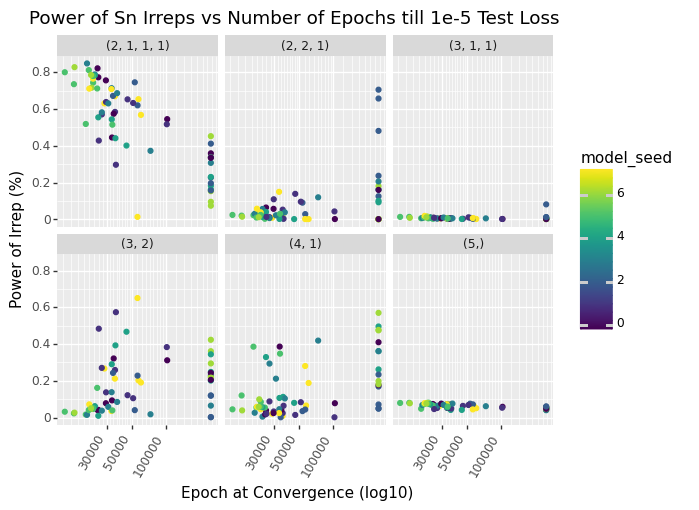

<ggplot: (364631989)>

In [55]:
from plotnine import scale_x_log10

(
    ggplot(df, aes(x='epoch', y='median_power', color='model_seed')) 
    + geom_point() 
    + facet_wrap('~irrep') 
    + scale_x_log10()
    + theme(axis_text_x=element_text(rotation=60, hjust=1))
    + xlab('Epoch at Convergence (log10)')
    + ylab('Power of Irrep (%)')
    + ggtitle('Power of Sn Irreps vs Number of Epochs till 1e-5 Test Loss ')
)

In [56]:
epoch_data = []

for ms, ds in product(model_seeds, data_seeds):
    fp = exp_dir / f'model_{ms}_data_{ds}/full_run.pth'
    full_run = torch.load(fp, map_location='cpu')
    epochs = full_run['checkpoint_epochs'][-1]
    epoch_data.append({'model_seed': ms, 'data_seed': ds, 'epochs': epochs})

epoch_df = pl.DataFrame(epoch_data)
    

In [65]:
epoch_df.groupby('data_seed').agg([
    pl.col('epochs').min().alias('min_epochs'),
    pl.col('epochs').mean().alias('mean_epochs'),
    pl.col('epochs').median().alias('median_epochs'),
    pl.col('epochs').max().alias('max_epochs')
]).sort('data_seed')

data_seed,min_epochs,mean_epochs,median_epochs,max_epochs
i64,i64,f64,f64,i64
10,19615,111635.0,37284.5,249999
11,22072,88203.0,31321.0,249999
12,15409,87987.375,41405.0,249999
13,24741,62273.125,34843.0,249999
14,20863,112199.875,35404.0,249999
15,12795,49114.75,35205.0,102841
16,21061,112284.875,40478.5,249999
17,21827,89142.625,39291.0,249999


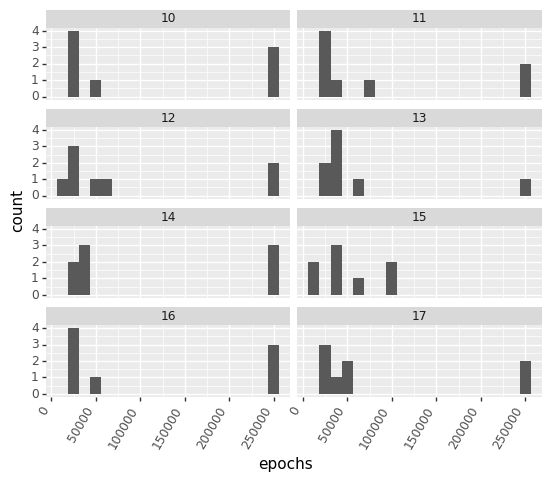

<ggplot: (700130124)>

In [108]:
ggplot(epoch_df, aes(x='epochs')) + geom_histogram(bins=20) + facet_wrap('~data_seed', nrow=4)+ theme(axis_text_x=element_text(rotation=60, hjust=1))

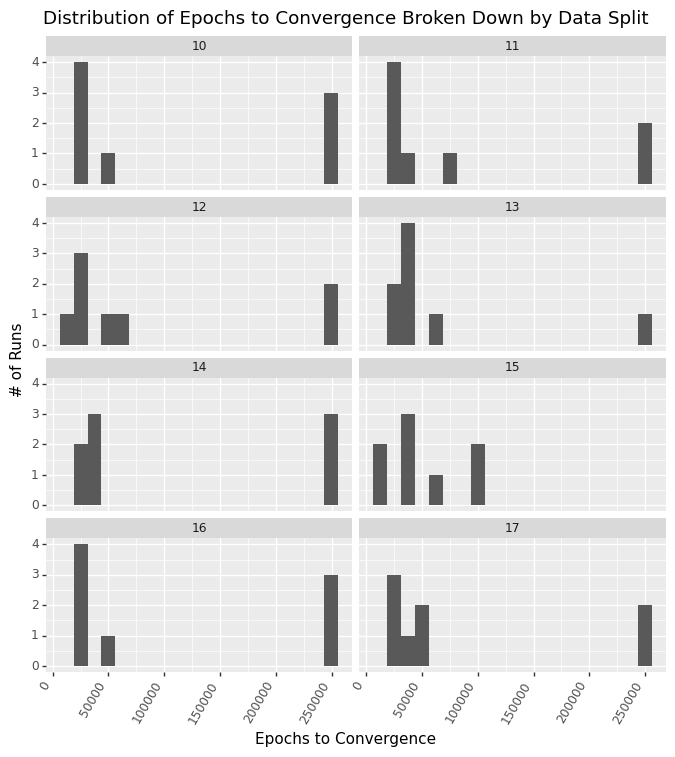

<ggplot: (728502203)>

In [116]:
(
    ggplot(epoch_df, aes(x='epochs')) 
    + geom_histogram(bins=20) 
    + facet_wrap('~data_seed', nrow=4)
    + theme(figure_size=(8, 8), axis_text_x=element_text(rotation=60, hjust=1))
    + xlab('Epochs to Convergence')
    + ylab('# of Runs')
    + ggtitle('Distribution of Epochs to Convergence Broken Down by Data Split')
)

In [98]:
epoch_df.groupby('model_seed').agg([
    pl.col('epochs').min().alias('min_epochs'),
    pl.col('epochs').mean().alias('mean_epochs'),
    pl.col('epochs').median().alias('median_epochs'),
    pl.col('epochs').max().alias('max_epochs')
]).sort('model_seed')

model_seed,min_epochs,mean_epochs,median_epochs,max_epochs
i64,i64,f64,f64,i64
0,24917,93833.0,34022.0,249999
1,25557,44180.375,35879.5,101993
2,34131,174193.5,249999.0,249999
3,20112,61925.75,32100.5,249999
4,23549,114112.0,40375.0,249999
5,12795,21575.875,21789.0,33684
6,15585,163684.875,249999.0,249999
7,21061,39335.25,34259.0,60258


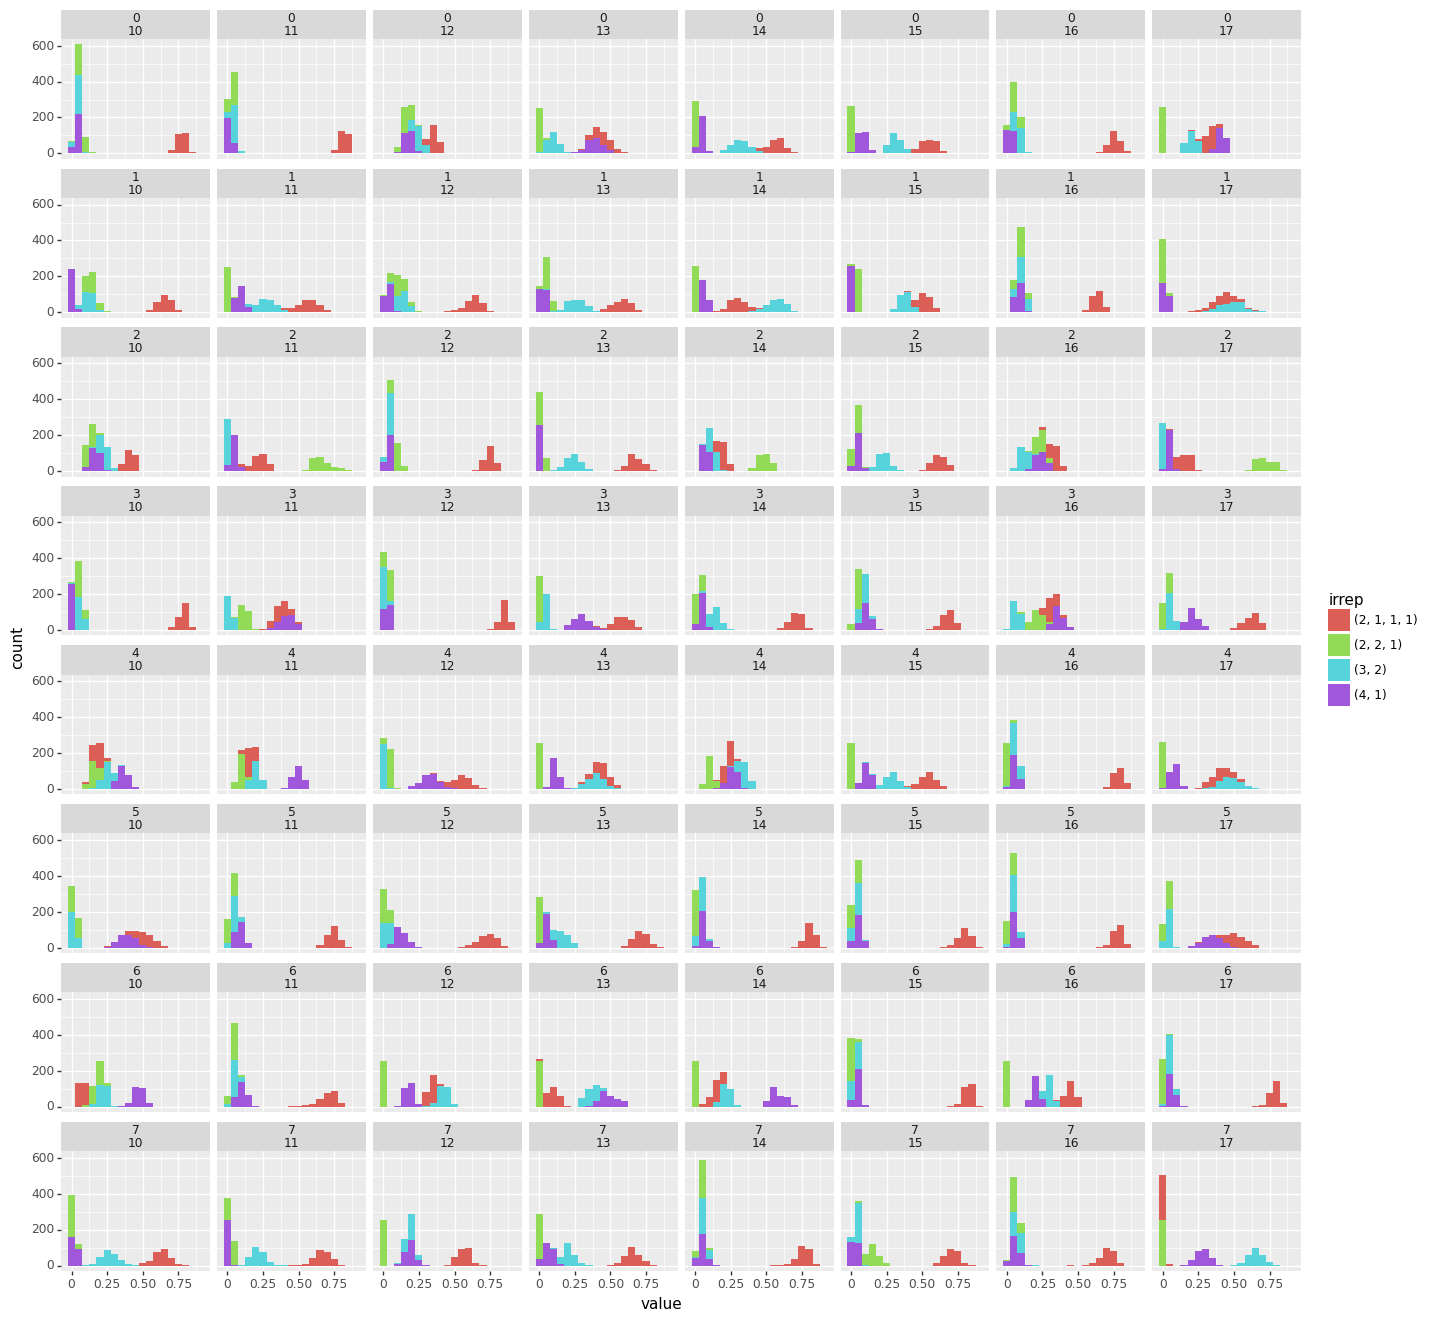

<ggplot: (1073008010)>

In [96]:
id_vars = ['model_seed', 'data_seed', 'epoch', 'irrep']

df = (all_data
      .filter((pl.col('layer') == 'left_embed')).select(pl.exclude('layer'))
      .melt(id_vars=id_vars)
      #.groupby(['model_seed', 'data_seed', 'epoch', 'irrep']).agg([
      #      pl.col('value').mean().alias('mean_power'),
      #      pl.col('value').median().alias('median_power'),
      #      pl.col('value').quantile(0.05).alias('q05'),
      #      pl.col('value').quantile(0.25).alias('q25'),
      #      pl.col('value').quantile(0.75).alias('q75'),
      #      pl.col('value').quantile(0.95).alias('q95')
      #3  ])
      ##.with_columns(pl.col('epoch').log())
      #.sort(['data_seed', 'model_seed', 'median_power'])
      .filter((pl.col('irrep') != "(1, 1, 1, 1, 1)") & (pl.col('irrep') != "(5,)") & (pl.col('irrep') != "(3, 1, 1)"))
      #.filter((pl.col('irrep') == "(2, 1, 1, 1)"))
    )

ggplot(df, aes(x='value', fill='irrep')) + geom_histogram(binwidth=0.05)  + facet_wrap('~model_seed+data_seed') + theme(figure_size=(16, 16))

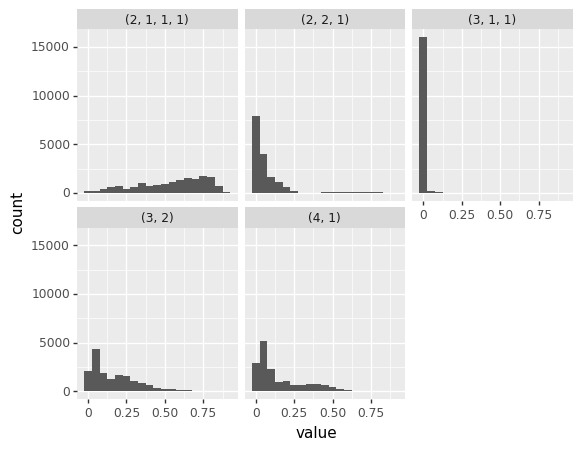

<ggplot: (1064589514)>

In [87]:
from plotnine import scale_y_log10

ggplot(df, aes(x='value', color='data_seed')) + geom_histogram(binwidth=0.05) + facet_wrap('~irrep')

In [200]:
from plotnine import scale_x_reverse

def rank_irreps(data):
    df_groups = []
    for name, df in data.groupby(['epoch', 'layer']):
        df_groups.append(df.with_columns(pl.col('median_power').rank().alias('rank')))

    ranked_df = pl.concat(df_groups)
    ranked_df = ranked_df.sort(['epoch', 'rank'])
    return ranked_df



def make_rank_plot(data, run):
    num_epochs = data['epoch'].max()
    small_loss_epoch = data.filter(pl.col('loss') <= 1e-4)['epoch'].min()
    plot = (
        ggplot(data, aes(x='loss', y='mean_power', color='factor(rank)'))
        + geom_line()
        + geom_text(aes(x=0.0001, y=0.3), color='black', label=f'{small_loss_epoch}/{num_epochs} epochs', ha='right')
        + geom_ribbon(aes(ymin='q25', ymax='q75', fill='factor(rank)'), alpha=0.5)
        + scale_x_log10()
        #+ scale_x_reverse()
        + facet_wrap('~layer')
        + theme(figure_size=(24, 16))
        + xlab('Test Loss') + ylab('Mean Proportion of Squared Norm')
        + geom_vline(xintercept=1e-4, size=1.5)
        #+ geom_text(x=2100, y=0.4, color='black', label='Max Test loss', ha='left')
        
        + ggtitle(f'Rank of Sn Irreps as Grokking Happens: {run}, {num_epochs} epochs')
    )
    return plot



def rank_training_plot(run, checkpoint_dir):
    run_dir = checkpoint_dir / run
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    loss = model_run['test_loss']

    #ft_dir = ckpt_dir / f'{run}/harmonics/ft'
    #ft_dir.mkdir(parents=True, exist_ok=True)

    embedding_data = []
    num_checkpoints = len(model_run['checkpoints'])
    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        data =  embedding_harmonic_analysis(ckpt, model_run['config'], epoch)
        embedding_data.append(data)
        #torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    
    linear_run_df = pl.concat(embedding_data, how='vertical')
    loss_df = pl.DataFrame({'epoch': model_run['checkpoint_epochs'], 'loss': loss})
    
    loss_df = loss_df.filter(pl.col('loss') <= 1.0)
    
    #embedding_run_df.write_parquet(f'checkpoints/{run}/harmonics/embed_power.parquet')
    run_power_summary = (
        linear_run_df
        .melt(id_vars=['epoch', 'layer', 'irrep'])
        .groupby(['epoch', 'layer', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').median().alias('median_power'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75'),
            pl.col('value').quantile(0.05).alias('q05'),
            pl.col('value').quantile(0.95).alias('q95')
        ])
        .sort(['epoch', 'layer', 'irrep'])
    )
    all_data = rank_irreps(run_power_summary.join(loss_df, on='epoch', how='inner'))
    
    return make_rank_plot(all_data, run)
    

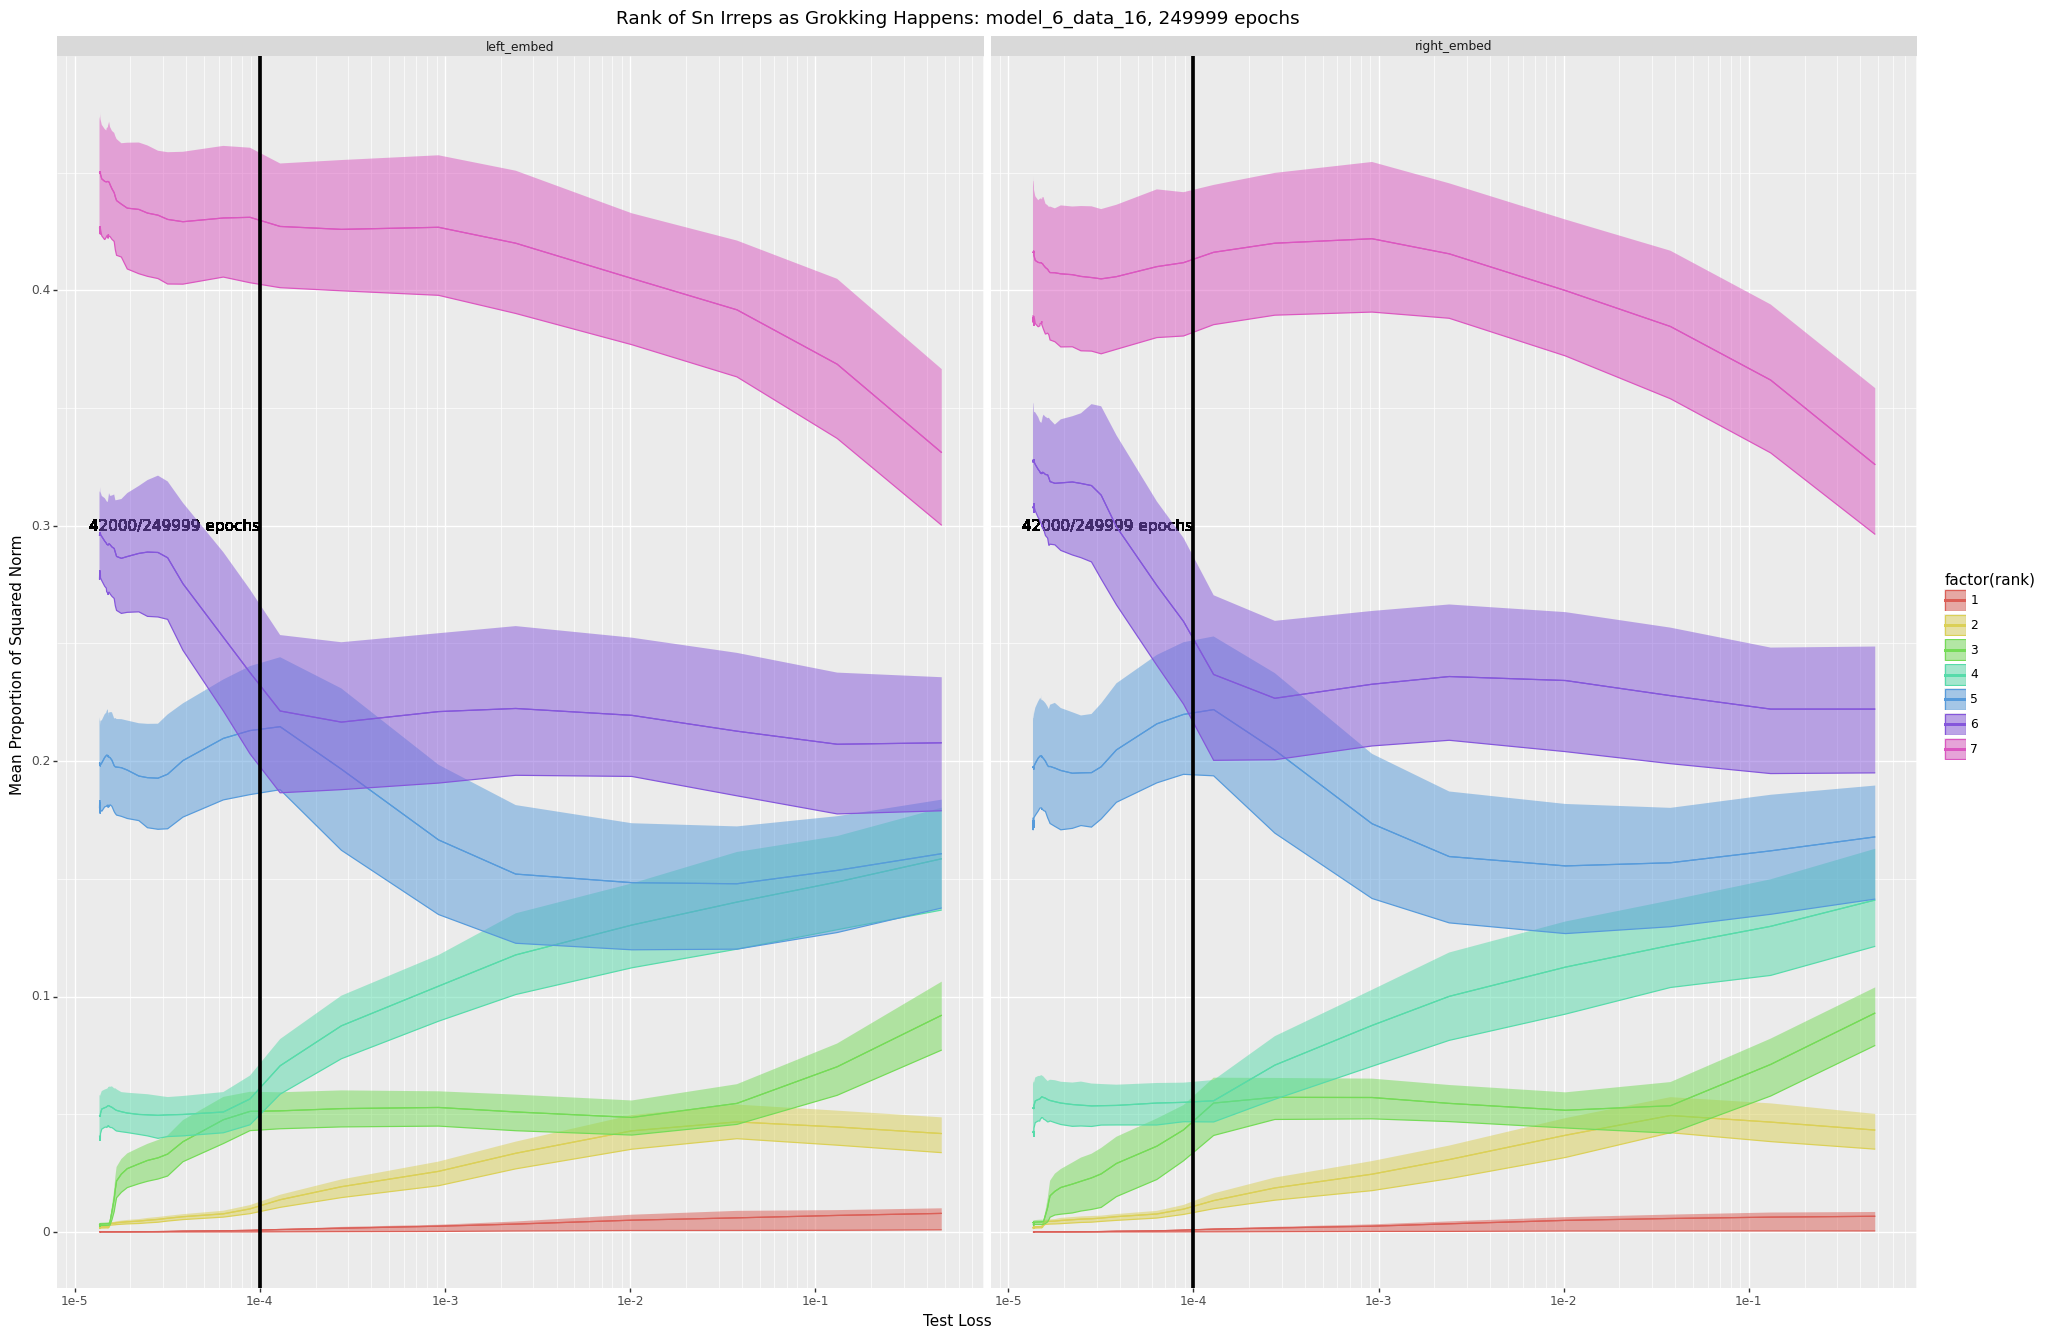

<ggplot: (727140325)>

In [201]:
rank_training_plot('model_6_data_16', exp_dir)

In [ ]:
from itertools import product


run_data = []

for ms, ds in product(model_seeds, data_seeds):
    run_name = f'model_{ms}_data_{ds}'
    plot = rank_training_plot(run_name, exp_dir)
    plot.save(f'plots/rank_zoom/{run_name}.png')

In [352]:
model_seed = 5
data_seed = 14
run_name = f'model_{model_seed}_data_{data_seed}'
run_dir = exp_dir / run_name
model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
loss = model_run['test_loss']
data = pl.read_parquet(exp_dir / f'data_{data_seed}.parquet')
lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])

out, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(out, targets)

linear_acts = cache['hook_linear']


In [353]:
from torch.nn.functional import relu

In [354]:
act_df = pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(128)])
act_df.insert_at_idx(0, data['index_target'])
act_df.head()

index_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,-0.005686,-0.1208,3.52426,0.361617,-0.087059,-0.984617,-6.040159,1.839442,0.054598,0.226404,12.990062,0.901365,-6.376374,1.514747,1.242684,-11.352985,0.214211,-0.013445,0.898549,-0.084864,0.114196,-0.000765,-0.056629,0.235005,0.379546,-0.111862,0.342254,0.149643,0.078725,-0.205203,-7.434313,5.554898,-6.92508,-1.874193,-0.341755,-0.994751,...,-7.362972,0.466148,0.385144,-0.223256,-0.152658,0.000157,0.010617,0.01418,-0.589286,-0.570941,1.999253,11.416732,0.370914,-0.017584,0.132352,-1.070313,1.131612,-6.084408,2.823614,0.656271,18.442333,-0.575288,-1.57619,7.688046,0.668209,-8.476028,13.675145,0.683005,-0.006233,-1.643815,1.200345,0.582125,-0.809124,-2.935477,-2.917259,0.709857,0.001663
1,-0.52188,-0.313294,3.691066,0.47344,0.737688,-0.05127,-6.040008,0.213556,-0.135347,0.187908,5.088829,-0.186024,-0.116609,1.60656,1.007734,-11.317111,0.829716,1.066809,0.380423,0.187258,-0.494138,-7.872607,-0.017964,0.280744,-0.463527,0.144532,0.689513,0.41154,1.423358,-0.502538,-5.026556,5.644258,-6.924628,-2.057116,0.748837,-0.303688,...,-7.361114,-0.418315,-0.195234,-0.077286,-0.902464,-2.26044,-0.049699,-1.427133,-0.409709,-0.030298,4.707312,11.360143,0.188787,-7.706087,0.239882,-0.131025,0.055895,-0.013231,6.320488,0.406644,13.662834,-0.143143,-0.875745,6.851894,-1.932808,-8.577871,10.161532,0.679943,6.401753,-1.693984,-0.190517,-0.214834,-0.614279,-2.872347,2.449829,0.485023,2.143492
2,-0.112286,-0.312424,3.611282,0.257133,0.053763,-0.524442,-6.022109,-5.81729,0.453039,-0.382808,7.693983,0.684217,0.015674,-4.316144,-1.264875,-11.316564,0.64746,5.6714,0.635136,-0.108905,0.755879,-2.094055,0.035175,0.043261,0.998881,-0.252909,-0.194803,-0.031893,-0.082082,-0.059008,0.046699,5.603401,-6.924998,-1.852212,-0.156238,-0.106051,...,-7.363811,-0.079319,0.335679,-0.287473,-1.08822,-0.966751,0.206768,-8.897555,-0.45303,0.747061,0.429544,11.366037,0.661554,-5.188855,-0.048123,-0.073823,0.27104,1.189951,0.091803,0.394103,10.68766,-1.147255,0.495533,-0.08654,-0.695751,-8.406708,17.713812,0.202141,4.147538,-2.173517,-0.114322,0.363812,-1.085958,-2.898513,-3.001242,-0.081592,0.918189
3,-0.417049,-0.152854,3.590478,-0.100421,0.70632,-0.090554,4.39294,-4.53502,0.319783,-0.334457,5.098962,0.239922,-14.298147,0.493681,2.054423,-11.316738,0.646906,1.071137,0.471626,0.051253,0.404469,-2.118947,-0.003041,0.019041,0.203774,0.026652,1.123778,-0.007044,0.042969,0.003964,-4.154058,5.580709,-6.924522,-1.935475,1.145077,-0.801411,...,-7.362975,-0.001761,0.246493,-0.223198,-1.595611,-2.859791,-0.0594,-6.281483,-0.401354,-0.465075,3.752467,11.366364,0.014916,-7.739741,0.368975,-0.620741,-0.574335,-14.856504,6.375974,0.397967,13.663626,0.361336,0.322821,4.407851,-1.158643,-9.896842,17.712156,0.733527,4.167341,-2.007108,-0.018242,0.292033,-0.384815,-2.910401,3.052204,0.55392,2.713955
4,0.138862,-0.244384,3.65394,0.566974,1.249838,-0.696853,9.161993,-4.724906,0.072221,0.189807,13.117456,0.82268,-14.297117,-2.665447,-0.966899,-11.317208,0.386842,0.00601,0.286183,-0.017661,0.439439,-7.828221,0.004578,0.126035,-0.393752,0.239226,-0.228861,0.170133,0.872713,-0.385247,-4.15737,5.631771,-6.924758,-1.939274,0.662228,-0.276572,...,-7.355826,0.16027,0.386626,-0.179417,-1.166046,0.442521,0.125754,-6.321575,-0.542258,0.6082

In [355]:
act_df.groupby('index_target').mean().sort('index_target')

index_target,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0.023534,0.030314,0.012174,0.02484,-0.001146,0.00601,0.010239,-0.035002,0.01376,0.000615,0.004636,0.009572,0.004655,-0.009564,0.021532,-0.000108,0.019841,-0.016367,0.029219,0.027319,0.010761,0.006919,-0.008715,0.018537,0.019597,0.02141,-0.009058,0.011621,-0.001602,0.010258,-0.00611,0.012152,-0.019396,-0.015686,0.028589,0.022253,...,0.008022,0.013118,0.035362,-0.026352,0.0222,0.001798,0.018931,0.000448,-0.007711,-0.011546,0.005566,0.000448,0.025227,0.008123,0.014261,-0.000536,0.020805,0.016368,0.04535,0.019355,0.009148,0.004821,0.013842,0.0175,-0.035766,0.045637,0.007144,0.020558,0.001916,-0.046499,-0.015188,0.013166,0.003289,-0.005958,-0.026745,0.02088,0.003465
1,0.023534,0.030314,0.012174,0.02484,-0.001146,0.00601,0.010239,-0.035002,0.01376,0.000615,0.004637,0.009572,0.004654,-0.009564,0.021532,-0.000107,0.019841,-0.016367,0.029219,0.027319,0.010761,0.00692,-0.008715,0.018537,0.019597,0.02141,-0.009058,0.011621,-0.001602,0.010258,-0.00611,0.012153,-0.019396,-0.015686,0.028589,0.022253,...,0.008022,0.013118,0.035362,-0.026352,0.0222,0.001798,0.018931,0.000448,-0.007711,-0.011546,0.005566,0.000447,0.025227,0.008123,0.014261,-0.000536,0.020805,0.016368,0.04535,0.019355,0.009148,0.004821,0.013842,0.0175,-0.035766,0.045637,0.007143,0.020558,0.001916,-0.0465,-0.015188,0.013166,0.003289,-0.005958,-0.026745,0.02088,0.003465
2,0.023534,0.030314,0.012174,0.02484,-0.001146,0.00601,0.010239,-0.035002,0.01376,0.000615,0.004637,0.009572,0.004655,-0.009564,0.021532,-0.000106,0.019841,-0.016367,0.029219,0.027319,0.010761,0.00692,-0.008715,0.018537,0.019597,0.02141,-0.009058,0.011621,-0.001602,0.010258,-0.00611,0.012153,-0.019396,-0.015686,0.028589,0.022253,...,0.008021,0.013118,0.035362,-0.026352,0.0222,0.001798,0.018931,0.000448,-0.007711,-0.011546,0.005566,0.000448,0.025227,0.008123,0.014261,-0.000536,0.020805,0.016368,0.04535,0.019355,0.009148,0.004821,0.013842,0.0175,-0.035766,0.045637,0.007144,0.020558,0.001916,-0.0465,-0.015188,0.013166,0.003289,-0.005958,-0.026746,0.02088,0.003465
3,0.023534,0.030314,0.012174,0.02484,-0.001146,0.00601,0.010239,-0.035002,0.01376,0.000615,0.004636,0.009572,0.004655,-0.009564,0.021532,-0.000107,0.019841,-0.016367,0.029219,0.027319,0.010761,0.00692,-0.008715,0.018537,0.019597,0.02141,-0.009058,0.011621,-0.001602,0.010258,-0.00611,0.012154,-0.019396,-0.015686,0.028589,0.022253,...,0.008022,0.013118,0.035362,-0.026352,0.0222,0.001798,0.018931,0.000448,-0.007711,-0.011546,0.005566,0.000449,0.025227,0.008123,0.014261,-0.000536,0.020805,0.016368,0.04535,0.019355,0.009148,0.004821,0.013842,0.0175,-0.035766,0.045637,0.007143,0.020558,0.001916,-0.046499,-0.015188,0.013166,0.003289,-0.005958,-0.026745,0.02088,0.003465
4,0.023534,0.030314,0.012174,0.02484,-0.001146,0.00601,0.010239,-0.035002,0.01376,0.000615,0.004637,0.009572,0.004655,-0.009564,0.021532,-0.000107,0.019841,-0.016367,0.029219,0.027319,0.010761,0.006919,-0.008715,0.018537,0.019597,0.02141,-0.009058,0.011621,-0.001602,0.010258,-0.00611,0.012154,-0.019395,-0.015686,0.028589,0.022253,...,0.008022,0.013118,0.035362,-0.026352,0.0222,0.001798,0.018931,0.000448,-0.007711,-0.011546,0.005566,0.000448,0.025227,0.008123,0.014261,-0.000536,0.020805,0.016368,0.04535,0.019355,0.009148,0.004821,0.013842,0.

In [356]:
act_df.melt(id_vars='index_target').filter((pl.col('index_target') < 15) & (pl.col('variable') == 'dim0')).head()

index_target,variable,value
i32,str,f32
0,"""dim0""",-0.005686
1,"""dim0""",-0.52188
2,"""dim0""",-0.112286
3,"""dim0""",-0.417049
4,"""dim0""",0.138862


/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


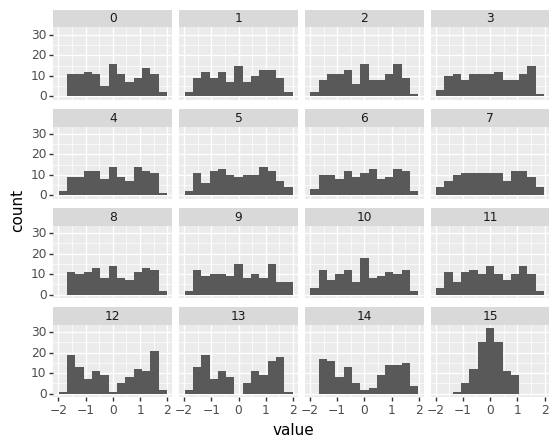

<ggplot: (985340634)>

In [357]:
(ggplot(
    act_df.melt(id_vars='index_target').filter((pl.col('index_target') < 16) & (pl.col('variable') == 'dim1')),
    aes(x='value'))
 + geom_histogram()
 + facet_wrap('~index_target')
)

In [246]:
target_sort_idx = torch.argsort(targets, stable=True)
linear_acts[1, :]

tensor([ 6.2048e+00, -7.1335e+00, -6.3379e+00,  4.6948e-01, -3.7704e-01,
        -1.6510e-01,  1.0022e-01, -5.0908e-03, -1.6613e+00, -1.2797e+00,
         5.9295e-05, -6.6856e-03, -2.3439e+00, -1.4350e+00, -9.2818e+00,
         7.2725e-05,  2.6920e+00,  1.6701e+00, -2.9957e+00, -2.1746e+00,
        -8.0386e+00,  2.0084e+00, -7.0987e-03, -7.9540e-01,  7.5526e-01,
        -1.7088e-03,  2.1147e+00,  5.5424e+00, -2.2842e+00, -3.1247e-02,
        -5.5496e+00, -1.6424e+00,  4.5733e-01,  8.7650e-05,  7.9426e-02,
        -3.0180e-02, -9.6729e+00,  1.5996e+00, -1.6783e-02,  4.8882e-01,
         6.8604e+00,  1.2324e+00,  7.8159e+00, -2.4437e+00,  3.3972e+00,
        -3.4612e+00, -3.4436e+00,  1.4055e+00,  6.8945e-01,  4.1703e+00,
        -8.9269e-01, -1.1996e+01, -1.4875e+00, -4.0325e+00, -3.0185e-01,
        -2.6532e-01, -7.8045e+00,  5.0945e-01,  7.5147e+00, -2.5550e-03,
         4.0309e+00, -3.2043e+00,  2.4414e+00,  8.7294e+00,  5.4934e-02,
        -2.0958e-01,  2.3853e-04,  6.9935e+00, -2.9

In [247]:
target_sort_idx[120:240]

tensor([    1,   120,   242,   366,   489,   603,   728,   844,   970,  1087,
         1211,  1325,  1453,  1574,  1692,  1836,  1944,  2088,  2197,  2330,
         2426,  2558,  2665,  2809,  2898,  3015,  3141,  3279,  3411,  3507,
         3645,  3750,  3894,  4002,  4137,  4233,  4339,  4463,  4577,  4721,
         4828,  4972,  5083,  5218,  5314,  5447,  5552,  5696,  5780,  5896,
         6022,  6160,  6293,  6389,  6526,  6631,  6775,  6884,  7019,  7115,
         7261,  7382,  7500,  7626,  7743,  7869,  7987,  8111,  8225,  8348,
         8464,  8590,  8713,  8832,  8954,  9096,  9228,  9324,  9458,  9565,
         9709,  9817,  9950, 10046, 10158, 10281, 10395, 10539, 10647, 10791,
        10902, 11037, 11133, 11265, 11370, 11514, 11600, 11716, 11842, 11980,
        12113, 12209, 12346, 12451, 12595, 12704, 12839, 12935, 13039, 13163,
        13277, 13421, 13528, 13672, 13783, 13918, 14014, 14147, 14252, 14396])

In [360]:
reshaped = relu(linear_acts[target_sort_idx]).reshape((120, 120, 128))

linear_means = reshaped.mean(dim=1)

In [361]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(128)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform

data, ft = calc_power_contributions(linear_means, 5)

In [348]:

reshaped_no_relu = linear_acts[target_sort_idx].reshape((120, 120, 128))

no_relu_means = reshaped_no_relu.mean(dim=1)
data_no_relu, ft = calc_power_contributions(no_relu_means, 5)

In [307]:
data.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)').head()

irrep,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,dim16,dim17,dim18,dim19,dim20,dim21,dim22,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32,dim33,dim34,dim35,...,dim91,dim92,dim93,dim94,dim95,dim96,dim97,dim98,dim99,dim100,dim101,dim102,dim103,dim104,dim105,dim106,dim107,dim108,dim109,dim110,dim111,dim112,dim113,dim114,dim115,dim116,dim117,dim118,dim119,dim120,dim121,dim122,dim123,dim124,dim125,dim126,dim127
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,...,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""(2, 1, 1, 1)""",0.004962,0.000009,0.185152,0.037923,0.000149,0.002479,0.198636,0.087599,0.005071,0.000105,0.198112,0.000386,0.198555,0.074469,0.087987,5.0548e-13,0.001452,0.198633,0.111353,0.005556,0.00037,0.199059,0.197033,0.00038,0.000209,0.001104,0.001736,0.00009,0.000332,0.000184,0.189542,0.198425,0.198542,0.000277,0.000366,0.000487,...,0.199037,0.00031,0.000107,0.001112,0.000099,1.5617e-9,0.009667,0.195885,0.001721,0.000108,0.078854,6.5359e-13,0.000234,0.19764,0.000828,0.000219,0.0005,0.197154,0.100262,0.000173,0.19883,0.001033,0.125986,0.153918,0.120025,0.188635,0.199111,0.000379,0.198817,0.085882,0.00033,0.000211,0.000777,0.193764,0.087935,0.000083,1.9900e-10
"""(2, 2, 1)""",0.000083,0.000049,0.000001,0.00036,0.000349,0.000152,6.0709e-10,0.001267,0.000205,0.000037,3.2860e-9,0.000506,4.7007e-10,0.001974,0.002069,1.1539e-12,0.000052,4.7745e-9,0.000036,0.000419,0.000027,1.1478e-10,3.0308e-8,0.000074,0.000277,0.000071,0.00032,0.045621,0.000122,0.038393,2.3701e-7,6.3502e-10,5.3170e-9,0.000045,0.000058,0.000033,...,7.4899e-11,0.00033,0.000136,0.000002,0.000989,1.9891e-9,0.000054,3.0745e-8,0.000002,0.000095,0.000814,6.3920e-13,0.000072,2.3999e-9,0.042925,0.000329,0.00014,1.8586e-9,0.009762,0.000424,1.9686e-10,0.000243,0.000058,0.000089,0.000132,4.2401e-8,1.9044e-10,0.000407,5.0622e-10,0.000044,0.000162,0.000245,0.000212,1.3866e-7,0.000658,0.00026,3.3611e-10
"""(3, 1, 1)""",0.000093,0.000003,0.000002,0.000114,0.00006,0.000078,7.6327e-10,0.000097,0.007848,0.000023,4.5469e-9,0.000043,5.1008e-10,0.000035,0.000184,1.5262e-12,0.000039,6.6596e-9,0.000065,0.000058,0.000026,1.9695e-10,3.5410e-8,0.01162,0.00005,0.010707,0.00003,0.000068,0.000464,0.000079,2.7615e-7,7.8380e-10,6.3787e-9,0.000014,0.00003,0.000007,...,9.1746e-11,0.000026,0.000031,0.000003,0.000046,2.3638e-9,0.000356,3.9010e-8,0.000003,0.000023,0.000485,6.3263e-13,0.000031,3.3123e-9,0.00002,0.000019,0.000067,2.1240e-9,0.000002,0.000274,2.7390e-10,0.000021,0.000054,0.000118,0.000138,4.7714e-8,2.0556e-10,0.000029,5.4437e-10,0.000002,0.000038,0.000039,0.000276,1.7195e-7,0.000767,0.00003,4.5927e-10
"""(3, 2)""",0.018939,0.000003,3.5311e-8,0.000197,0.000008,0.000035,4.2591e-11,0.000002,0.000419,0.0593,6.0714e-10,0.05657,1.1823e-10,0.00002,0.000019,1.1566e-12,0.029086,2.7546e-9,0.000001,0.001828,0.044244,6.7656e-11,4.1001e-9,0.000438,0.000025,0.000112,0.052859,0.000128,0.000029,0.000186,1.7966e-8,1.1465e-10,2.2674e-9,0.000003,0.000007,0.049633,...,1.7446e-11,0.044364,0.041775,0.000001,0.00012,0.164131,0.000675,2.6686e-9,6.7148e-7,0.070049,0.000007,6.0733e-13,0.041136,1.1974e-9,0.000028,0.057205,0.000013,9.5400e-10,5.5027e-7,0.000017,6.7575e-11,0.057112,0.000002,9.4034e-7,0.000001,9.6241e-9,3.9754e-11,0.000041,1.7007e-10,3.5455e-7,0.055782,0.04928,0.000018,9.4451e-9,0.000042,0.045794,0.163875
"""(4, 1)""",0.000101,0.08016,2.5104e-8,0.000023,0.095868,0.05832,3.2857e-11,2.0674e-7,0.00016,0.000035,4.7094e-10,0.000045,9.3204e-11,2.2760e-7,5.0809e-7,4.9188e-13,0.000041,1.7487e-9,0.000007,0.000168,0.000044,4.6443e-11,1.3248e-9,0.000052,0.067604,0.001287,0.000089,0.000132,0.083177,0.000111,5.6633e-9,6.1144e-11,9.0531e-10,0.137481,0.073839,0.000014,...,1.6770e-11,0.000022,0.000042,0.14948,0.07125,1.5612e-9,0.000223,3.6961e-9,0.135462,0

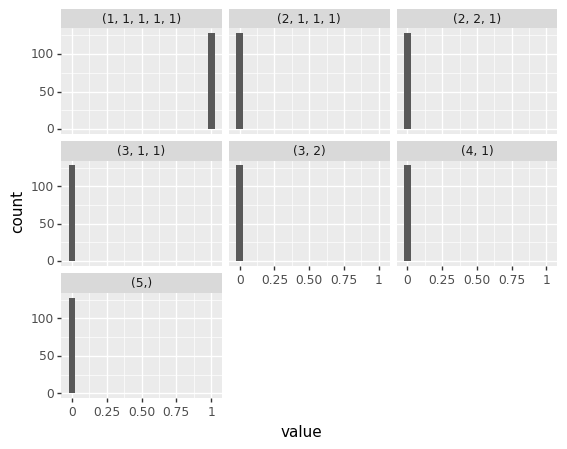

<ggplot: (368814762)>

In [350]:
(ggplot(
    data_no_relu.melt(id_vars='irrep'), aes(x='value')
) + geom_histogram(binwidth=0.05) + facet_wrap('~irrep')
)

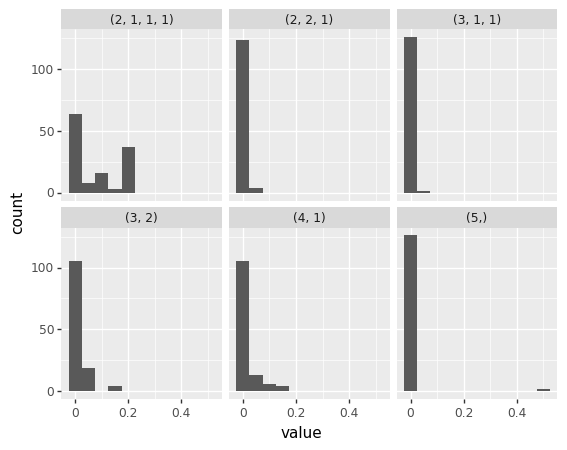

<ggplot: (1067188891)>

In [308]:
(ggplot(
    data.filter(pl.col('irrep') != '(1, 1, 1, 1, 1)').melt(id_vars='irrep'), aes(x='value')
) + geom_histogram(binwidth=0.05) + facet_wrap('~irrep')
)

In [310]:
def calc_power_contributions_2d(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)**2
    fourier_transform = slow_ft_2d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(128)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform

linear_data, ft2d = calc_power_contributions_2d(relu(linear_acts), 5)

In [314]:
linear_no_relu, ft2d_no_relu =  calc_power_contributions_2d(linear_acts, 5)

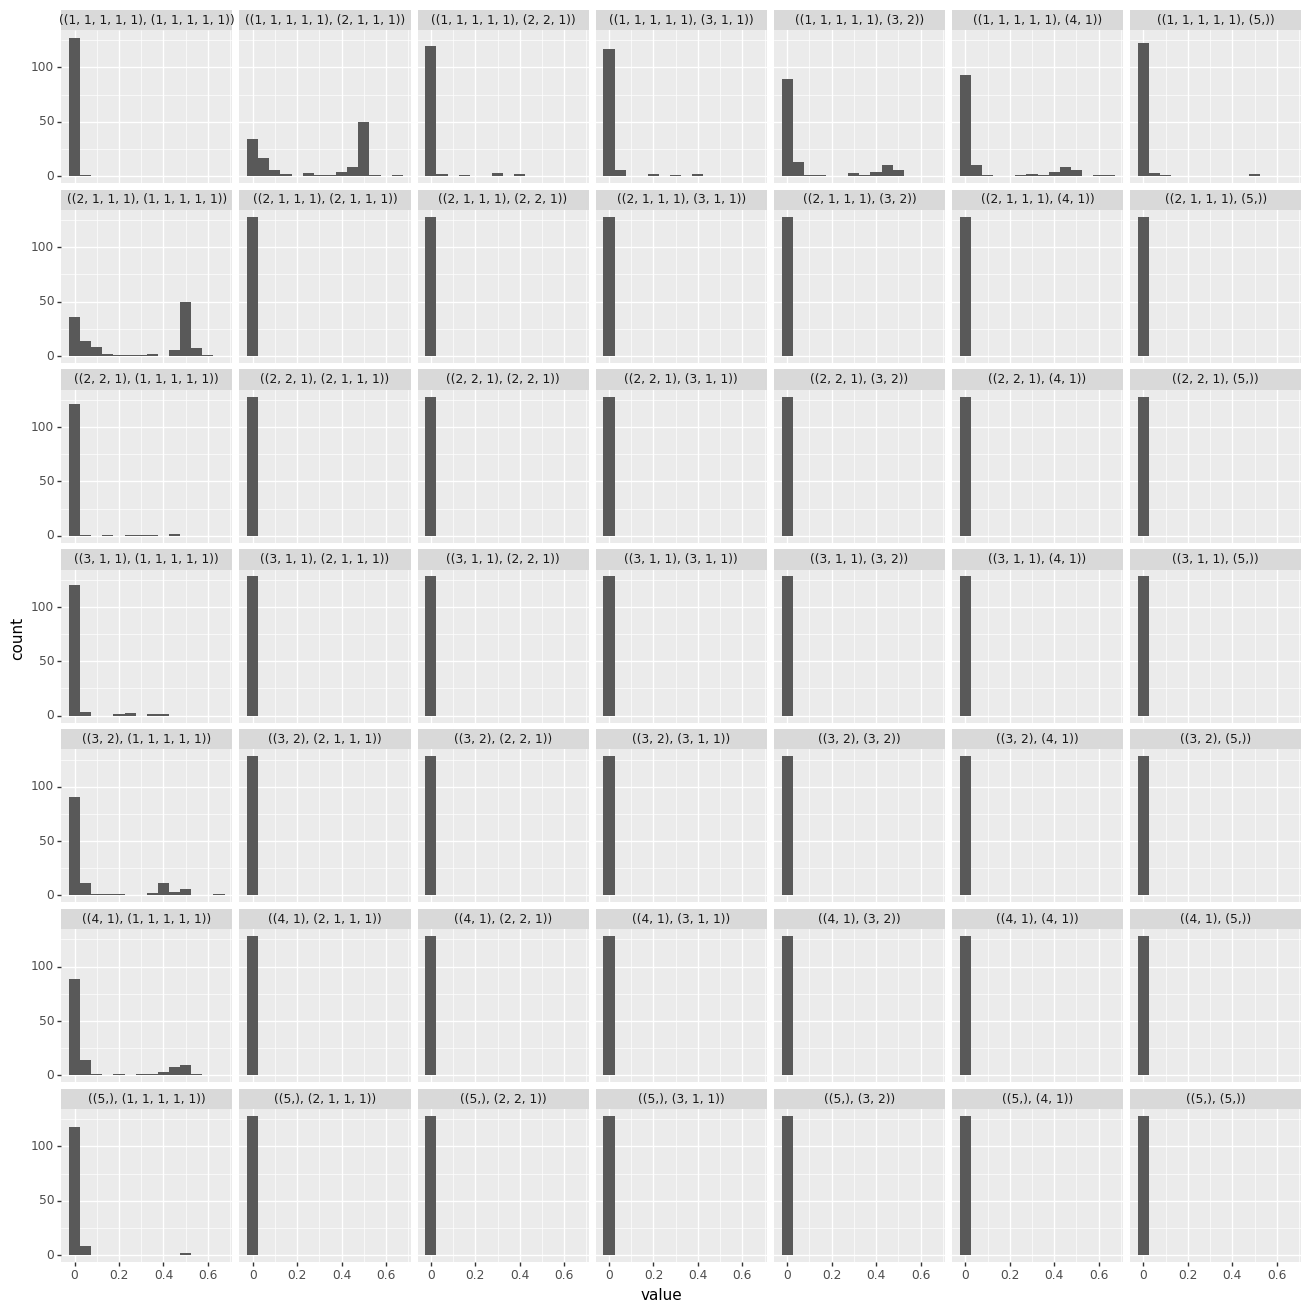

<ggplot: (1069696196)>

In [316]:
(ggplot(
    linear_no_relu.melt(id_vars='irrep'), aes(x='value')
) + geom_histogram(binwidth=0.05) 
  + facet_wrap('~irrep') 
  + theme(figure_size=(16, 16))
)

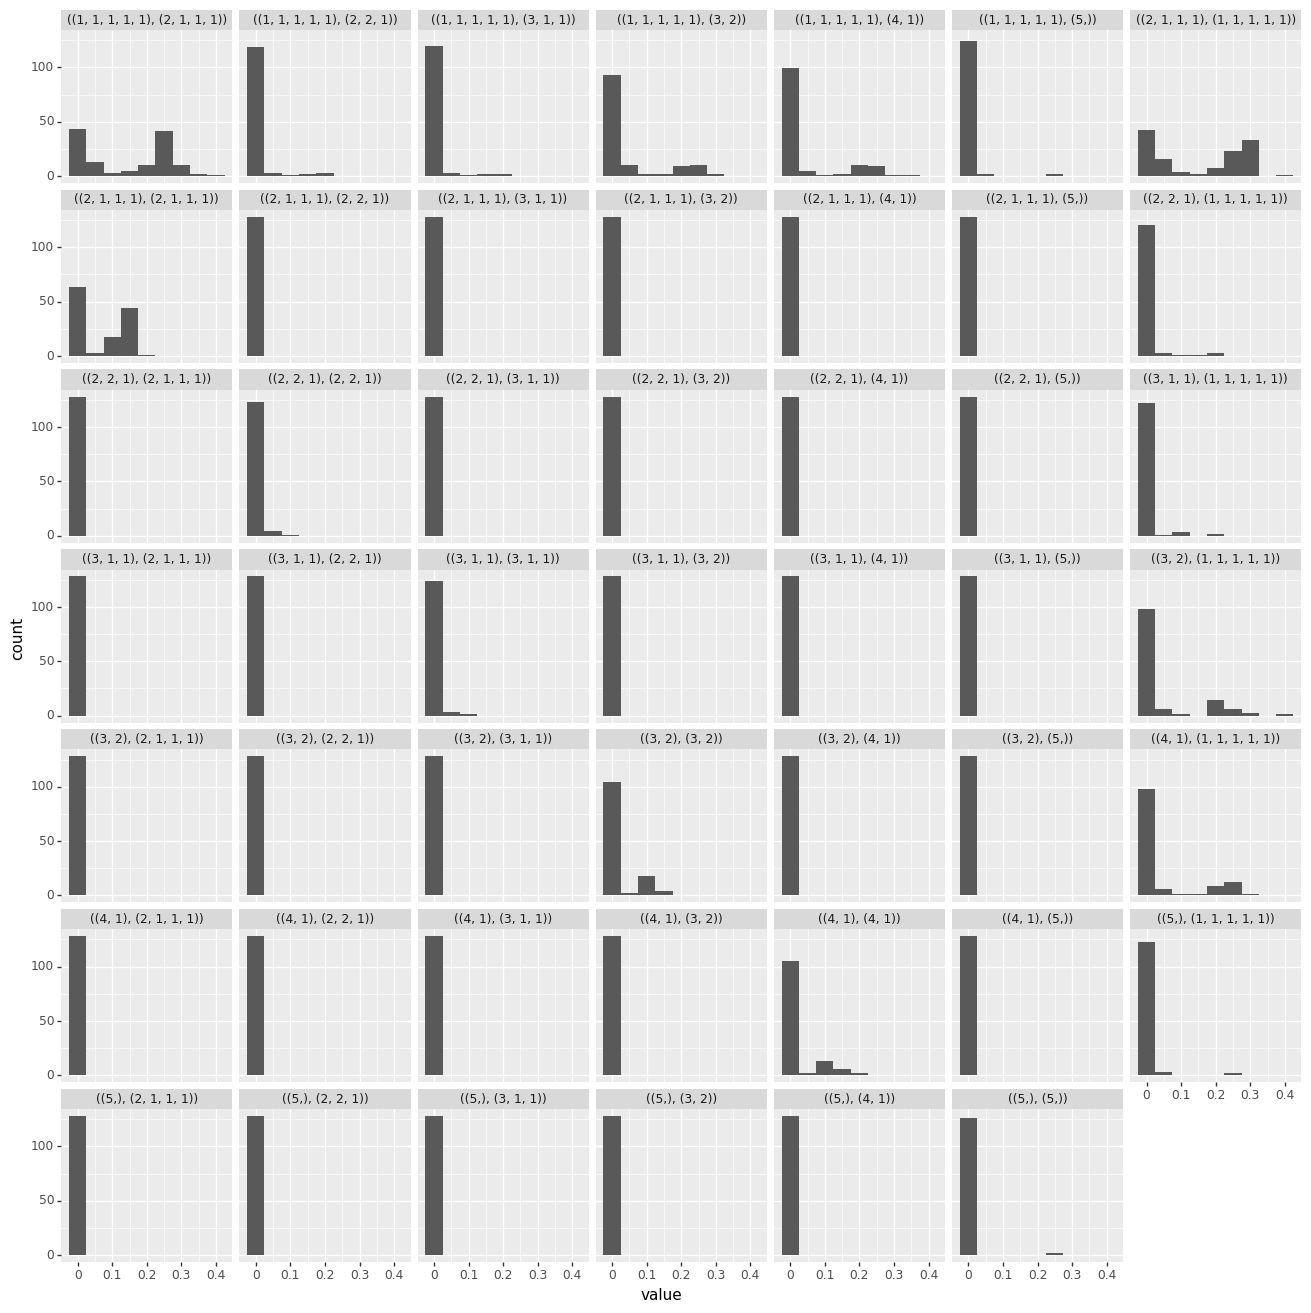

<ggplot: (974209568)>

In [313]:
(ggplot(
    linear_data.filter(pl.col('irrep') != '((1, 1, 1, 1, 1), (1, 1, 1, 1, 1))').melt(id_vars='irrep'), aes(x='value')
) + geom_histogram(binwidth=0.05)
  + facet_wrap('~irrep') 
  + theme(figure_size=(16, 16))
)

In [364]:
mainirreps_dims_2d = linear_data.melt(id_vars='irrep').filter((pl.col('irrep') == '((2, 1, 1, 1), (2, 1, 1, 1))')).sort('value').tail(60)['variable'].to_list()

In [365]:

mainirreps_dims_1d = data.melt(id_vars='irrep').filter((pl.col('irrep') == '(2, 1, 1, 1)')).sort('value').tail(60)['variable'].to_list()
len(set(mainirreps_dims_1d).intersection(set(mainirreps_dims_2d)))

60

In [ ]:
def linear_harmonic_analysis(checkpoint, config, epoch, lperms, rperms , targets):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    
    out, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(out, targets[test_mask])
    
    linear_acts = cache['hook_linear']
    target_sort_idx = torch.argsort(targets)
    
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight, 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight, 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return (
        pl.concat([lembed_power_df, rembed_power_df], how='vertical'),
        loss
    )



def linear_data_by_output(model_seed, data_seed, checkpoint_dir):
    run = f'model_{model_seed}_data_{data_seed}'
    run_dir = checkpoint_dir / run
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    data = pl.read_parquet(checkpoint_dir / f'data_{data_seed}.parquet')
    mask = torch.asarray(~ data['in_train'].cast(pl.Boolean).to_numpy())
    lperms = torch.as_tensor(data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

    #ft_dir = ckpt_dir / f'{run}/harmonics/ft'
    #ft_dir.mkdir(parents=True, exist_ok=True)

    embedding_data = []
    losses = []
    num_checkpoints = len(model_run['checkpoints'])
    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        data, loss =  embedding_harmonic_analysis(ckpt, model_run['config'], epoch, lperms, rperms, targets, mask)
        embedding_data.append(data)
        losses.append(loss.mean().item())
        #torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    
    linear_run_df = pl.concat(embedding_data, how='vertical')
    loss_df = pl.DataFrame({'epoch': model_run['checkpoint_epochs'][:num_checkpoints], 'test_loss': losses})
    peaks = loss_df['test_loss'].peak_max().arg_true()
    if len(peaks) == 1:
        peak_idx = peaks.item()
    else:
        print(loss_df['test_loss'][peaks])
        peak_idx = peaks[0]
    peak_epoch = model_run['checkpoint_epochs'][peak_idx]
    loss_df = loss_df.with_columns(pl.col('epoch').apply(lambda x: 'before_peak' if x <= peak_epoch else 'after_peak').alias('peak_group'))
    #embedding_run_df.write_parquet(f'checkpoints/{run}/harmonics/embed_power.parquet')
    run_power_summary = (
        linear_run_df
        .melt(id_vars=['epoch', 'layer', 'irrep'])
        .groupby(['epoch', 'layer', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').median().alias('median_power'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75'),
            pl.col('value').quantile(0.05).alias('q05'),
            pl.col('value').quantile(0.95).alias('q95')
        ])
        .sort(['epoch', 'layer', 'irrep'])
    )
    all_data = rank_irreps(run_power_summary.join(loss_df, on='epoch', how='inner'))
    
    plot = make_rank_plot(all_data, run)
    plot.save(f'plots/irrep_rank/{run}.png')

In [368]:
def generate_subgroup(generators: list[tuple[int]]):
    group_size = 0
    all_perms = set(generators)
    while group_size < len(all_perms):
        group_size = len(all_perms)
        perms = [Permutation(p) for p in all_perms]
        for perm1, perm2 in product(perms, repeat=2):
            perm3 = perm1 * perm2
            all_perms.add(perm3.sigma)
    return list(all_perms)

sg = generate_subgroup([(4, 0,1,2,3)])
len(sg)

5

In [369]:
sg

[(4, 0, 1, 2, 3),
 (3, 4, 0, 1, 2),
 (1, 2, 3, 4, 0),
 (2, 3, 4, 0, 1),
 (0, 1, 2, 3, 4)]

In [370]:
from itertools import permutations

all_perms = [Permutation(p) for p in permutations([0, 1, 2, 3, 4])]
five_cycles = [p for p in all_perms if p.conjugacy_class == (5,)]
five_cycles

[Permutation [1, 2, 3, 4, 0],
 Permutation [1, 2, 4, 0, 3],
 Permutation [1, 3, 0, 4, 2],
 Permutation [1, 3, 4, 2, 0],
 Permutation [1, 4, 0, 2, 3],
 Permutation [1, 4, 3, 0, 2],
 Permutation [2, 0, 3, 4, 1],
 Permutation [2, 0, 4, 1, 3],
 Permutation [2, 3, 1, 4, 0],
 Permutation [2, 3, 4, 0, 1],
 Permutation [2, 4, 1, 0, 3],
 Permutation [2, 4, 3, 1, 0],
 Permutation [3, 0, 1, 4, 2],
 Permutation [3, 0, 4, 2, 1],
 Permutation [3, 2, 0, 4, 1],
 Permutation [3, 2, 4, 1, 0],
 Permutation [3, 4, 0, 1, 2],
 Permutation [3, 4, 1, 2, 0],
 Permutation [4, 0, 1, 2, 3],
 Permutation [4, 0, 3, 1, 2],
 Permutation [4, 2, 0, 1, 3],
 Permutation [4, 2, 3, 0, 1],
 Permutation [4, 3, 0, 2, 1],
 Permutation [4, 3, 1, 0, 2]]

In [387]:

def get_cosets():
    all_perms = [Permutation(p) for p in permutations([0, 1, 2, 3, 4])]
    five_cycles = [p for p in all_perms if p.conjugacy_class == (5,)]
    all_fives = set([p.sigma for p in five_cycles])
    cosets = []
    while len(all_fives) > 0:
        perm = Permutation(all_fives.pop())
        cycle = [(perm ** i).sigma for i in range(1, 5)]
        cosets.append(cycle)
        all_fives -= set(cycle)
    return cosets
        


In [388]:
cosets = get_cosets()
[len(c) for c in cosets]

[4, 4, 4, 4, 4, 4]

In [397]:
g1 = (4, 0, 1, 2, 3) #(1,2,3,4,5)
g2 = (0, 3, 1, 4,2) # (1,2,4,3) 

print(Permutation(g1).conjugacy_class)

Permutation(g2).conjugacy_class

(5,)


(4, 1)

In [400]:
from itertools import product

def get_frob_cosets():
    all_perms = [Permutation(p) for p in permutations([0, 1, 2, 3, 4])]
    five_cycles = [p.sigma for p in all_perms if p.conjugacy_class == (5,)]
    four_cycles = [p.sigma for p in all_perms if p.conjugacy_class == (4, 1)]
    generator_subgroups = {}
    for four_cyc, five_cyc in product(four_cycles, five_cycles):
        subgroup = generate_subgroup([four_cyc, five_cyc])
        if len(subgroup) == 20:
            subgroup = tuple(sorted(subgroup))
            if subgroup not in generator_subgroups:
                generator_subgroups[subgroup] = [[four_cyc, five_cyc]]
            else:
                generator_subgroups[subgroup].append([four_cyc, five_cyc])
    return generator_subgroups
                
    
frob20_groups = get_frob_cosets()
    

In [405]:
groups = list(frob20_groups.keys())


In [412]:
frob20_groups[groups[5]][0]

[(0, 3, 4, 2, 1), (1, 4, 0, 2, 3)]

In [374]:
all_fives = set([p.sigma for p in five_cycles])
all_fives.pop()

(2, 4, 3, 1, 0)

In [375]:
len(all_fives)

23

In [382]:
five_cycles[0]**5

Permutation [0, 1, 2, 3, 4]

In [413]:
import numpy as np

In [416]:
i = np.eye(2)
j = np.array([[0., 1.], [1., 0.]])


In [419]:
np.kron(j, i)

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [486]:
st = np.sqrt(2) / 2
b1 = np.array([[1, 0], [0, 1], [1, 0], [0, 1]])
b2 = np.array([[1, 0, -1, 0], [0, -1, 0, 1]])

In [430]:
basis.T @ np.kron(i, j) @ basis

array([[0., 1.],
       [1., 0.]])

In [434]:
S3 = SnIrrep(3, (2, 1))

In [440]:
s3_mats = S3.matrix_representations()

In [441]:
list(s3_mats.keys())

[(1, 0, 2), (0, 2, 1), (2, 1, 0), (0, 1, 2), (1, 2, 0), (2, 0, 1)]

In [503]:
s1 = (1, 0, 2)
s2 = (2, 1, 0)
prod = (Permutation(s1) * Permutation(s2)).sigma
print(f'{s1} * {s2} == {prod}')
print(np.kron(s3_mats[s1], s3_mats[s2]))
print(s3_mats[prod])

(1, 0, 2) * (2, 1, 0) == (1, 2, 0)
[[-0.5        0.8660254  0.        -0.       ]
 [ 0.8660254  0.5       -0.        -0.       ]
 [ 0.        -0.         0.5       -0.8660254]
 [-0.        -0.        -0.8660254 -0.5      ]]
[[-0.5        0.8660254]
 [-0.8660254 -0.5      ]]


In [509]:

def get_inverse(p1, p2):
    prod = (Permutation(p1) * Permutation(p2)).sigma
    print(f'{p1} * {p2} == {prod}')
    a = np.kron(s3_mats[p1], s3_mats[p2])
    b = np.kron(s3_mats[prod], s3_mats[prod])
    print(np.linalg.solve(a, b))
    

In [510]:
get_inverse((1, 0, 2), (2, 1, 0))

(1, 0, 2) * (2, 1, 0) == (1, 2, 0)
[[ 0.25       0.4330127 -0.4330127 -0.75     ]
 [ 0.4330127 -0.25      -0.75       0.4330127]
 [-0.4330127 -0.75      -0.25      -0.4330127]
 [-0.75       0.4330127 -0.4330127  0.25     ]]


In [511]:
get_inverse((2, 1, 0), (1, 0, 2))

(2, 1, 0) * (1, 0, 2) == (2, 0, 1)
[[-5.00000000e-01 -8.66025404e-01  6.40987562e-17  1.28197512e-16]
 [-8.66025404e-01  5.00000000e-01  1.28197512e-16 -6.40987562e-17]
 [ 2.40370336e-17  4.80740672e-17  5.00000000e-01  8.66025404e-01]
 [ 4.80740672e-17 -2.40370336e-17  8.66025404e-01 -5.00000000e-01]]


In [512]:
get_inverse((2, 1, 0), (0,1, 2))

(2, 1, 0) * (0, 1, 2) == (2, 1, 0)
[[ 5.00000000e-01 -8.66025404e-01  3.20493781e-17 -6.40987562e-17]
 [-8.66025404e-01 -5.00000000e-01 -6.40987562e-17 -3.20493781e-17]
 [ 2.40370336e-17 -4.80740672e-17  5.00000000e-01 -8.66025404e-01]
 [-4.80740672e-17 -2.40370336e-17 -8.66025404e-01 -5.00000000e-01]]


In [513]:
get_inverse((2, 0, 1), (1, 0, 2))

(2, 0, 1) * (1, 0, 2) == (2, 1, 0)
[[ 5.00000000e-01 -8.66025404e-01 -3.20493781e-17  6.40987562e-17]
 [ 8.66025404e-01  5.00000000e-01 -6.40987562e-17 -3.20493781e-17]
 [-2.40370336e-17  4.80740672e-17 -5.00000000e-01  8.66025404e-01]
 [-4.80740672e-17 -2.40370336e-17 -8.66025404e-01 -5.00000000e-01]]


(1, 0, 2)
[[ 1. -0. -0.  0.]
 [-0. -1.  0.  0.]
 [-0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]
################
################
(0, 2, 1)
[[ 0.25       0.4330127  0.4330127  0.75     ]
 [ 0.4330127 -0.25       0.75      -0.4330127]
 [ 0.4330127  0.75      -0.25      -0.4330127]
 [ 0.75      -0.4330127 -0.4330127  0.25     ]]
################
################
(2, 1, 0)
[[ 0.25      -0.4330127 -0.4330127  0.75     ]
 [-0.4330127 -0.25       0.75       0.4330127]
 [-0.4330127  0.75      -0.25       0.4330127]
 [ 0.75       0.4330127  0.4330127  0.25     ]]
################
################
(0, 1, 2)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
################
################
(1, 2, 0)
[[ 0.25      -0.4330127 -0.4330127  0.75     ]
 [ 0.4330127  0.25      -0.75      -0.4330127]
 [ 0.4330127 -0.75       0.25      -0.4330127]
 [ 0.75       0.4330127  0.4330127  0.25     ]]
################
################
(2, 0, 1)
[[ 0.25       0.4330127  0.4330127  0.75     ]
 [-0.4330127  0.25

In [516]:
def get_kron(p1, p2):
    return np.kron(s3_mats[p1], s3_mats[p2])
    

In [517]:
for perm, mat in S3.matrix_representations().items():
    print(perm)
    print(np.kron(mat, mat))
    print('################')
    print('################')

(1, 0, 2)
[[ 1. -0. -0.  0.]
 [-0. -1.  0.  0.]
 [-0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]
################
################
(0, 2, 1)
[[ 0.25       0.4330127  0.4330127  0.75     ]
 [ 0.4330127 -0.25       0.75      -0.4330127]
 [ 0.4330127  0.75      -0.25      -0.4330127]
 [ 0.75      -0.4330127 -0.4330127  0.25     ]]
################
################
(2, 1, 0)
[[ 0.25      -0.4330127 -0.4330127  0.75     ]
 [-0.4330127 -0.25       0.75       0.4330127]
 [-0.4330127  0.75      -0.25       0.4330127]
 [ 0.75       0.4330127  0.4330127  0.25     ]]
################
################
(0, 1, 2)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
################
################
(1, 2, 0)
[[ 0.25      -0.4330127 -0.4330127  0.75     ]
 [ 0.4330127  0.25      -0.75      -0.4330127]
 [ 0.4330127 -0.75       0.25      -0.4330127]
 [ 0.75       0.4330127  0.4330127  0.25     ]]
################
################
(2, 0, 1)
[[ 0.25       0.4330127  0.4330127  0.75     ]
 [-0.4330127  0.25

In [525]:
get_kron((2, 1, 0), (1, 2, 0))

array([[-0.25     ,  0.4330127,  0.4330127, -0.75     ],
       [-0.4330127, -0.25     ,  0.75     ,  0.4330127],
       [ 0.4330127, -0.75     ,  0.25     , -0.4330127],
       [ 0.75     ,  0.4330127,  0.4330127,  0.25     ]])

In [526]:
get_inverse((2, 1, 0), (1, 2, 0))

(2, 1, 0) * (1, 2, 0) == (0, 2, 1)
[[ 5.00000000e-01 -3.70074342e-17 -8.66025404e-01  0.00000000e+00]
 [ 2.40370336e-17 -5.00000000e-01 -2.40370336e-17  8.66025404e-01]
 [ 8.66025404e-01  0.00000000e+00  5.00000000e-01  5.55111512e-17]
 [-4.16333634e-17 -8.66025404e-01  4.16333634e-17 -5.00000000e-01]]


In [528]:
get_kron((1, 2, 0), (2, 1, 0))

array([[-0.25     ,  0.4330127, -0.4330127,  0.75     ],
       [ 0.4330127,  0.25     ,  0.75     ,  0.4330127],
       [ 0.4330127, -0.75     , -0.25     ,  0.4330127],
       [-0.75     , -0.4330127,  0.4330127,  0.25     ]])

In [529]:
get_kron((0, 1, 2), (2, 1, 0)) @ get_kron((2, 1, 0), (1, 2, 0)) @ get_kron((1, 2, 0), (0, 1, 2))

array([[ 0.25     ,  0.4330127,  0.4330127,  0.75     ],
       [ 0.4330127, -0.25     ,  0.75     , -0.4330127],
       [ 0.4330127,  0.75     , -0.25     , -0.4330127],
       [ 0.75     , -0.4330127, -0.4330127,  0.25     ]])

In [530]:
get_kron((0, 2, 1), (0, 2, 1))

array([[ 0.25     ,  0.4330127,  0.4330127,  0.75     ],
       [ 0.4330127, -0.25     ,  0.75     , -0.4330127],
       [ 0.4330127,  0.75     , -0.25     , -0.4330127],
       [ 0.75     , -0.4330127, -0.4330127,  0.25     ]])

In [534]:
np.kron(s3_mats[(1, 2, 0)], np.array([[1.], [1.], [1.]]))

array([[-0.5      ,  0.8660254],
       [-0.5      ,  0.8660254],
       [-0.5      ,  0.8660254],
       [-0.8660254, -0.5      ],
       [-0.8660254, -0.5      ],
       [-0.8660254, -0.5      ]])

In [541]:
np.kron(np.array([1., 1.]), s3_mats[(2, 1, 0)]) @ get_kron((2, 1, 0), (1, 2, 0))

array([[-0.1830127, -0.3169873, -0.6830127, -1.1830127],
       [-0.3169873,  0.1830127, -1.1830127,  0.6830127]])

In [546]:
np.kron(np.array([1]), s3_mats[(2, 1, 0)]) @ get_kron((1, 2, 0), (2, 1, 0)) @ np.kron(s3_mats[(1, 2, 0)], np.array([[1.], [1.]]))

array([[ 0.3660254, -1.3660254],
       [ 0.3660254, -1.3660254]])

In [542]:
np.kron(s3_mats[(1, 2, 0)], np.array([[1.], [1.]]))

array([[-0.5      ,  0.8660254],
       [-0.5      ,  0.8660254],
       [-0.8660254, -0.5      ],
       [-0.8660254, -0.5      ]])

In [544]:
s3_mats[(0, 2, 1)]

array([[ 0.5      ,  0.8660254],
       [ 0.8660254, -0.5      ]])

In [549]:
np.kron(s3_mats[(1, 2, 0)], np.array([[1.], [1.]]))

array([[-0.5      ,  0.8660254],
       [-0.5      ,  0.8660254],
       [-0.8660254, -0.5      ],
       [-0.8660254, -0.5      ]])